### Imports

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from utils import Format_Dataset

### Create MLP

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 3),
            nn.Softmax(),
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

### Instantiate Model, Criterion, and Optimizer

In [34]:
model = MLP()

# def criterion(out, label):
#     return (label - out) ** 2

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-1)

### Create Dataset

In [55]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples in each distribution
num_samples = 300

# Generate data for three distributions in 2D
data_c1 = np.random.multivariate_normal(mean=[-2, 2], cov=[[1, 0.5], [0.5, 1]], size=num_samples)
data_c2 = np.random.multivariate_normal(mean=[-1, -3], cov=[[1, 0.5], [0.5, 1]], size=num_samples)
data_c3 = np.random.exponential(scale=1, size=(num_samples, 2)) + np.array([2.0, 1.5])

# Assign labels to each class
labels_c1 = np.zeros((num_samples, 1))
labels_c2 = np.ones((num_samples, 1))
labels_c3 = 2 * np.ones((num_samples, 1))

# Concatenate data and labels for each class
class_1 = np.hstack((data_c1, labels_c1))
class_2 = np.hstack((data_c2, labels_c2))
class_3 = np.hstack((data_c3, labels_c3))

# Combine all classes into a single dataset
dataset = np.vstack((class_1, class_2, class_3))

dataset_labels = torch.tensor(dataset[:, 2])
dataset_labels = dataset_labels.long()

# Apply one-hot encoding
one_hot_labels = F.one_hot(dataset_labels, num_classes=3)

# Shuffle the dataset
# np.random.shuffle(dataset)

dataset_dict = {'samples': dataset[:, :2], 'labels': one_hot_labels} 
train = Format_Dataset(dataset_dict, choice = 'Train')
train.samples = train.samples.to(torch.float32)
train.labels = train.labels.to(torch.float32)
train = torch.utils.data.DataLoader( shuffle = False,
                                        dataset = train, 
                                        batch_size = 30 ) 

# Plot the distributions
plt.scatter(dataset[dataset[:, 2] == 0][:, 0], dataset[dataset[:, 2] == 0][:, 1], label='Normal Distribution', alpha=1.0, c='blue')
plt.scatter(dataset[dataset[:, 2] == 1][:, 0], dataset[dataset[:, 2] == 1][:, 1], label='Uniform Distribution', alpha=1.0, c='green')
plt.scatter(dataset[dataset[:, 2] == 2][:, 0], dataset[dataset[:, 2] == 2][:, 1], label='Exponential Distribution', alpha=1.0, c='black')

plt.title('Two-Dimensional Distributions with Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### Perform Experiment

In [35]:
for epoch in range(100):
    for data, labels in train:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()





/Users/rchristopher/mambaforge/envs/nn/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


/Users/rchristopher/mambaforge/envs/nn/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


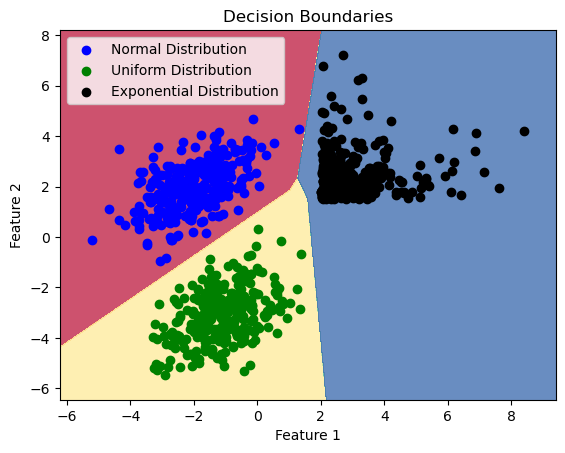

In [54]:
# Create a meshgrid for visualization
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

grid_tensor = torch.tensor(np.c_[x_grid.ravel(), y_grid.ravel()], dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions = model(grid_tensor)
    _, predicted_labels = torch.max(predictions, 1)

decision_regions = predicted_labels.numpy().reshape(x_grid.shape)

plt.contourf(x_grid, y_grid, decision_regions, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(dataset[dataset[:, 2] == 0][:, 0], dataset[dataset[:, 2] == 0][:, 1], label='Normal Distribution', alpha=1.0, c='blue')
plt.scatter(dataset[dataset[:, 2] == 1][:, 0], dataset[dataset[:, 2] == 1][:, 1], label='Uniform Distribution', alpha=1.0, c='green')
plt.scatter(dataset[dataset[:, 2] == 2][:, 0], dataset[dataset[:, 2] == 2][:, 1], label='Exponential Distribution', alpha=1.0, c='black')

plt.title('Decision Boundaries')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()